# Create polygons based on TCW

- Get tiles
- Threshold TCW value
- Convert to polygon

### May need to run again to install

In [1]:
!pip install python-geohash

Processing /home/jovyan/.cache/pip/wheels/6f/be/45/5e0a0ce5bf42f2081c5b2906d4f1f146f825ec00c3759d1bd3/python_geohash-0.8.5-cp36-cp36m-linux_x86_64.whl


### Import modules

In [2]:
import rasterio
from shapely.geometry import Polygon, shape, mapping
from shapely.ops import unary_union
import geopandas as gp
import fiona
from fiona.crs import from_epsg
import xarray as xr
import pandas as pd
import glob
import os.path
import math
import geohash as gh
import re
import numpy as np
import matplotlib.pyplot as plt
import rasterio.features as ft

In [3]:
pwd

'/home/jovyan/dev/dea-notebooks/Gabrielle_dev/LCCS_wet_veg'

In [4]:
# # Open into an xarray.DataArray
# tcw_ds = xr.open_dataset('ls_tcw_percentiles/LS_TCW_PC_11_-40_19870101_20181025.nc')
# tcw_ds

In [5]:
# # Open into an xarray.DataArray
# wofs_ds = xr.open_dataset('ls_tcw_percentiles/WOFS_3577_11_-40_summary.nc')
# wofs_ds

In [6]:
# plt.imshow(wofs_ds.TCW_PC_90.isel(time=0))#.plot()

### Set up the functions for this script

In [7]:
# # Grab a list of all of the netCDF files in the tile folder
# TileFiles = glob.glob(f"{TileFolder}*.nc")
# print('TileFiles',TileFiles)
# print()
# CustomRegionAlbersTiles = set()
# for filePath in TileFiles:
#     AlbersTiles = re.split("[_\.]", filePath)
#     print(AlbersTiles)
#     # Test that the albers tile numbers are actually where we expect them to be in the file name
#     try:
#         int(AlbersTiles[-5])
#         int(AlbersTiles[-4])
#         print(int(AlbersTiles[-5]),int(AlbersTiles[-4]))
#     except ValueError:
#         print(
#             "** ERROR ** \n"
#             'The netCDF files are expected to have the file format "*/wofs_filtered_summary_8_-37.nc",\n'
#             "with the Albers tile numbers in the 2nd and 3rd last positions when separated on `_` and `.`. \n"
#             "Please fix the file names, or alter the `Generate_list_of_albers_tiles` function."
#         )
# ThisTile = f"{AlbersTiles[-5]}_{AlbersTiles[-4]}"
# print('ThisTile',ThisTile)

In [8]:
def Generate_list_of_albers_tiles(TileFolder="TileFolder", CustomData=True):
    if os.path.exists(TileFolder) == False:
        print(
            "** ERROR ** \n"
            "You need to specify a folder of files for running a custom region")
        return

    # Grab a list of all of the netCDF files in the tile folder
    TileFiles = glob.glob(f"{TileFolder}*.nc")
    print('TileFiles',TileFiles)

    CustomRegionAlbersTiles = set()
    for filePath in TileFiles:
        AlbersTiles = re.split("[_\.]", filePath)
        print()
        print('AlbersTiles',AlbersTiles)
        print()
        if CustomData:
            #Test that the albers tile numbers are actually where we expect them to be in the file name
            try:
                int(AlbersTiles[-5])
                int(AlbersTiles[-4])
            except ValueError:
                print(
                    "** ERROR ** \n"
                    'The netCDF files are expected to have the file format "*/wofs_summary_8_-37_{date}.nc",\n'
                    "with the Albers tile numbers in the 2nd and 3rd last positions when separated on `_`. \n"
                    "Please fix the file names, or alter the `Generate_list_of_albers_tiles` function."
                )
                return

            # Now that we're happy that the file is reading the correct Albers tiles
            ThisTile = f"{AlbersTiles[-4]}_{AlbersTiles[-3]}"
        else:
            # Test that the albers tile numbers are actually where we expect them to be in the file name
            try:
                int(AlbersTiles[-5])
                int(AlbersTiles[-4])
                print(int(AlbersTiles[-5]),int(AlbersTiles[-4]))
                print()
            except ValueError:
                print(
                    "** ERROR ** \n"
                    'The netCDF files are expected to have the file format "*/wofs_filtered_summary_8_-37.nc",\n'
                    "with the Albers tile numbers in the 2nd and 3rd last positions when separated on `_` and `.`. \n"
                    "Please fix the file names, or alter the `Generate_list_of_albers_tiles` function."
                )
                return

            # Now that we're happy that the file is reading the correct Albers tiles
            ThisTile = f"{AlbersTiles[-5]}_{AlbersTiles[-4]}"
            print('ThisTile',ThisTile)
        CustomRegionAlbersTiles.add(ThisTile)
    CustomRegionAlbersTiles = list(CustomRegionAlbersTiles)
    return CustomRegionAlbersTiles

In [9]:
# CustomData

In [10]:
# TileFolder

In [11]:
# Generate_list_of_albers_tiles(TileFolder, CustomData)

In [12]:
def Generate_list_of_tile_datasets(ListofAlbersTiles,
                                   Year,
                                   TileFolder="TileFolder",
                                   CustomData=True):

    if os.path.exists(TileFolder) == False:
        print(
            "** ERROR ** \n"
            "You need to specify a folder of files for running a custom region")
        raise

    Alltilespaths = []

    if CustomData:
        for tile in ListofAlbersTiles:
            Tiles = glob.glob(f"{TileFolder}*_{tile}_{Year}.nc")
            Alltilespaths.append(
                Tiles[0])  # Assumes only one file will be returned
    else:
        for tile in ListofAlbersTiles:
            # Use glob to check that the file actually exists in the format we expect
            Tiles = glob.glob(f"{TileFolder}LS_TCW_PC_{tile}_19870101_20181025.nc")
            print('Tiles',Tiles)
            # Check that assumption by seeing if the returned list is empty
            if not Tiles:
                Tiles = glob.glob(f"{TileFolder}WOFS_3577_{tile}_summary.nc") #Gabrielle
#                 Tiles = glob.glob(f"{TileFolder}LS_TCW_PC_{tile}_198710101_20181025.nc")
            # Check that we actually have something now
            if not Tiles:
                print(
                    "** ERROR ** \n"
                    "An assumption in the file naming conventions has gone wrong somewhere.\n"
                    "We assume two file naming formats here: {TileFolder}wofs_filtered_summary_{tile}.nc, \n"
                    "and {TileFolder}WOFS_3577_{tile}_summary.nc. The files you have directed to don't meet \n"
                    "either assumption. Please fix the file names, or alter the `Generate_list_of_albers_tiles` function."
                )
            Alltilespaths.append(
                Tiles[0])  # Assumes only one file will be returned

    return Alltilespaths

In [13]:
# ListofAlbersTiles

In [14]:
# Year= '19870101_20181025'

In [15]:
# Generate_list_of_tile_datasets(ListofAlbersTiles,
#                                    Year,
#                                    TileFolder,
#                                    CustomData)

In [16]:
def Filter_shapefile_by_intersection(gpdData,
                                     gpdFilter,
                                     filtertype="intersects",
                                     invertMask=True,
                                     returnInverse=False):
    # Check that the coordinate reference systems of both dataframes are the same

    # assert gpdData.crs == gpdFilter.crs, 'Make sure the the coordinate reference systems of the two provided dataframes are the same'

    Intersections = gp.sjoin(gpdFilter, gpdData, how="inner", op=filtertype)

    # Find the index of all the polygons that intersect with the filter
    IntersectIndex = sorted(set(Intersections["index_right"]))

    # Grab only the polygons NOT in the IntersectIndex
    # i.e. that don't intersect with a river
    if invertMask:
        gpdDataFiltered = gpdData.loc[~gpdData.index.isin(IntersectIndex)]
    else:
        gpdDataFiltered = gpdData.loc[gpdData.index.isin(IntersectIndex)]

    if returnInverse:
        # We need to use the indices from IntersectIndex to find the inverse dataset, so we
        # will just swap the '~'.

        if invertMask:
            gpdDataInverse = gpdData.loc[gpdData.index.isin(IntersectIndex)]
        else:
            gpdDataInverse = gpdData.loc[~gpdData.index.isin(IntersectIndex)]

        return gpdDataFiltered, IntersectIndex, gpdDataInverse
    else:

        return gpdDataFiltered, IntersectIndex

### Set switches

In [17]:
AllOfAustraliaAllTime = False

CustomData = False
AutoGenerateTileList = False

### Set locations

In [18]:
if CustomData:
    # Path to the files you would like to use for the analysis
    TileFolder = '/g/data/r78/cek156/datacube_stats/WOFSDamsAllTimeNSWMDB/'
else:
    # Default path to the WOfS summary product
    TileFolder = 'ls_tcw_percentiles/'

In [19]:
## Set up some file names for the inputs and outputs
# The name and filepath of the intermediate output polygon set
WaterBodiesShp = f'output/temp/'

# The name and filepath of the temp, filtered output polygon set
WOFSshpMerged = f'output/'
WOFSshpFiltered = 'output/AusWaterBodiesFiltered.shp'

# Final shapefile name
FinalName = 'output/AusWaterBodies.shp'

### Choose aoi

In [24]:
# We only want to generate the tile list if we are not doing all of Australia.
if not AllOfAustraliaAllTime:
    if AutoGenerateTileList:
        ListofAlbersTiles = Generate_list_of_albers_tiles(
            TileFolder, CustomData)
    else:
        # Provide you own list of tiles to be run
        ListofAlbersTiles = [
        '14_-35'
        ]

### Choose threshold

In [25]:
AtLeastThisWet = [-350]

### The process

In [29]:
# First, test whether the wetness threshold has been correctly set
if len(AtLeastThisWet) == 2:
    print(
        f'We will be running a hybrid wetness threshold. Please ensure that the major threshold is \n'
        f'listed second, with the supplementary threshold entered first.'
        f'**You have set {AtLeastThisWet[-1]} as the primary threshold,** \n'
        f'**with {AtLeastThisWet[0]} set as the supplementary threshold.**')
elif len(AtLeastThisWet) == 1:
    print(
        f'You have not set up the hybrid threshold option. If you meant to use this option, please \n'
        f'set this option by including two wetness thresholds in the `AtLeastThisWet` variable above. \n'
        f'The wetness threshold we will use is {AtLeastThisWet}.')
else:
    raise ValueError(
        f'There is something wrong with your entered wetness threshold. Please enter a list \n'
        f'of either one or two numbers. You have entered {AtLeastThisWet}. \n'
        f'See above for more information')

You have not set up the hybrid threshold option. If you meant to use this option, please 
set this option by including two wetness thresholds in the `AtLeastThisWet` variable above. 
The wetness threshold we will use is [-350].


In [30]:
# Now perform the analysis to generate the first iteration of polygons
for year in range(1980, 1981):

    ### Get the list of netcdf file names to loop through
    if AllOfAustraliaAllTime:
        # Grab everything from the published WOfS all time summaries
        Alltiles = glob.glob(f'{TileFolder}*.nc')
        print('1',Alltiles)
    else:
        Alltiles = Generate_list_of_tile_datasets(ListofAlbersTiles, year,
                                                  TileFolder, CustomData)
        print('2',Alltiles)
        
# Check this prints out thing
# e.g. 2 ['ls_tcw_percentiles/WOFS_3577_14_-35_summary.nc']

Tiles []
2 ['ls_tcw_percentiles/WOFS_3577_14_-35_summary.nc']


In [31]:
MinimumValidObs = 0

In [32]:
pwd

'/home/jovyan/dev/dea-notebooks/Gabrielle_dev/LCCS_wet_veg'

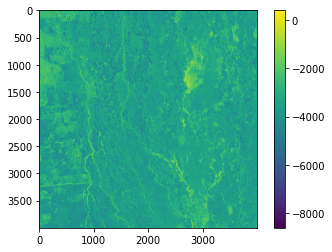

In [34]:
# Read in the data
# Note that the netCDF files we are using here contain a variable called 'frequency',
# which is what we are using to define our water polygons.
# If you use a different netCDF input source, you may need to change this variable name here
WOFSnetCDFData = xr.open_rasterio(f'NETCDF:ls_tcw_percentiles/WOFS_3577_14_-35_summary.nc:TCW_PC_10') #Gabrielle dev/dea-notebooks/Gabrielle_dev/LCCS_wet_veg/ls_tcw_percentiles/WOFS_3577_11_-40_summary.nc
# Remove the superfluous time dimension
WOFSnetCDFData = WOFSnetCDFData.squeeze()
plt.imshow(WOFSnetCDFData)
plt.colorbar()

# # Open the clear count variable to generate the minimum observation mask
# # If you use a different netCDF input source, you may need to change this variable name here
# WOFSvalidcount = xr.open_rasterio(f'NETCDF:{WOFSfile}:count_clear')
# WOFSvalidcount = WOFSvalidcount.squeeze()
# # plt.imshow(WOFSvalidcount)

# # Filter our WOfS classified data layer to remove noise
# # Remove any pixels not abserved at least MinimumValidObs times
# WOFSValidFiltered = WOFSvalidcount >= MinimumValidObs
# # plt.imshow(WOFSValidFiltered)

In [35]:
Thresholds = 0

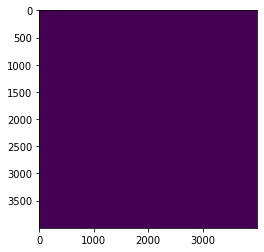

In [36]:
# Remove any pixels that are wet < AtLeastThisWet% of the time
WOFSfiltered = WOFSnetCDFData > Thresholds
plt.imshow(WOFSfiltered)

In [37]:
np.unique(WOFSfiltered)

array([False,  True])

In [38]:
WOFSfiltered = WOFSfiltered.where((WOFSfiltered != 0))
np.unique(WOFSfiltered)

array([ 1., nan, nan, ..., nan, nan, nan])

In [39]:
# # Now find pixels that meet both the MinimumValidObs and AtLeastThisWet criteria
# # Change all zeros to NaN to create a nan/1 mask layer
# # Pixels == 1 now represent our water bodies
# WOFSfiltered = WOFSfiltered.where((WOFSfiltered == 1))
# plt.imshow(WOFSfiltered)
# plt.colorbar()

In [40]:
# Convert the raster to polygons
# We use a mask of '1' to only generate polygons around values of '1' (not NaNs)
WOFSpolygons = ft.shapes(
    WOFSfiltered.data.astype('float32'),
    mask=WOFSfiltered.data.astype('float32') == 1,
    transform=WOFSnetCDFData.transform)
# The rasterio.features.shapes returns a tuple. We only want to keep the geometry portion,
# not the value of each polygon (which here is just 1 for everything)
WOFSbreaktuple = (a for a, b in WOFSpolygons)
print('WOFSbreaktuple',WOFSbreaktuple)

# Put our polygons into a geopandas geodataframe
PolygonGP = gp.GeoDataFrame(list(WOFSbreaktuple))
# print('PolygonGP',PolygonGP)

# Grab the geometries and convert into a shapely geometry
# so we can quickly calcuate the area of each polygon
# PolygonGP['geometry'] = None
# for ix, poly in PolygonGP.iterrows():
#     poly['geometry'] = shape(poly)
PolygonGP['geometry'] = None
for i, row in PolygonGP.iterrows():
    PolygonGP.at[i,'geometry'] = shape(row)
print('Set geometries bit',PolygonGP)

# Set the geometry of the dataframe to be the shapely geometry we just created
PolygonGP = PolygonGP.set_geometry('geometry')
# We need to add the crs back onto the dataframe
PolygonGP.crs = ('EPSG:3577')

# print('PolygonGP',PolygonGP)

# # Combine any overlapping polygons
# MergedPolygonsGeoms = unary_union(PolygonGP['geometry'])
# print('MergedPolygonsGeoms',MergedPolygonsGeoms)

MergedPolygonsGPD = PolygonGP

# # Turn the combined multipolygon back into a geodataframe
# MergedPolygonsGPD = gp.GeoDataFrame(
#     [poly for poly in MergedPolygonsGeoms])
# # Rename the geometry column
# MergedPolygonsGPD.columns = ['geometry']
# # We need to add the crs back onto the dataframe
# MergedPolygonsGPD.crs = ('EPSG:3577')

# Calculate the area of each polygon again now that overlapping polygons
# have been merged
MergedPolygonsGPD['area'] = MergedPolygonsGPD['geometry'].area
print(MergedPolygonsGPD['area'])

WOFSbreaktuple <generator object <genexpr> at 0x7fbd80817af0>
Set geometries bit        type                                        coordinates  \
0   Polygon  [[(1404775.0, -3418700.0), (1404775.0, -341872...   
1   Polygon  [[(1404750.0, -3418725.0), (1404750.0, -341875...   
2   Polygon  [[(1433100.0, -3421725.0), (1433100.0, -342175...   
3   Polygon  [[(1444650.0, -3426200.0), (1444650.0, -342622...   
4   Polygon  [[(1435650.0, -3427375.0), (1435650.0, -342740...   
5   Polygon  [[(1439325.0, -3427475.0), (1439325.0, -342750...   
6   Polygon  [[(1439275.0, -3427500.0), (1439275.0, -342752...   
7   Polygon  [[(1435150.0, -3429900.0), (1435150.0, -342992...   
8   Polygon  [[(1425450.0, -3433700.0), (1425450.0, -343372...   
9   Polygon  [[(1434075.0, -3434975.0), (1434075.0, -343502...   
10  Polygon  [[(1415700.0, -3440225.0), (1415700.0, -344025...   
11  Polygon  [[(1456975.0, -3497875.0), (1456975.0, -349790...   

                                             geometry  
0   

In [41]:
# # Check area
# PolygonGP['geometry'].area.max()

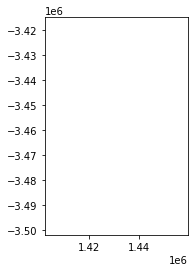

In [42]:
# Plot polygon to see
MergedPolygonsGPD.plot()

In [43]:
# PolygonGP['geometry']

### Save the polygons to a shapefile

In [44]:
# Save the polygons to a shapefile
schema = {
    'geometry': 'Polygon',
    'properties': {
        'area': 'float'
    }
}

# Generate our dynamic filename
FileName = f'{WaterBodiesShp}Mac_PC10_{Thresholds}.shp'
# Append the file name to the list so we can call it later on

if os.path.isfile(FileName):
    with fiona.open(FileName,
                    "a",
                    crs=from_epsg(3577),
                    driver='ESRI Shapefile',
                    schema=schema) as output:
        for ix, poly in MergedPolygonsGPD.iterrows():
            output.write(({
                'properties': {
                    'area': poly['area']
                },
                'geometry': mapping(shape(poly['geometry']))
            }))
else:
    with fiona.open(FileName,
                    "w",
                    crs=from_epsg(3577),
                    driver='ESRI Shapefile',
                    schema=schema) as output: 
        for ix, poly in MergedPolygonsGPD.iterrows():
            output.write(({
                'properties': {
                    'area': poly['area']
                },
                'geometry': mapping(shape(poly['geometry']))
            }))

In [ ]:
### Whole thing

In [ ]:
# Now perform the analysis to generate the first iteration of polygons
for year in range(1980, 1981):

    ### Get the list of netcdf file names to loop through
    if AllOfAustraliaAllTime:
        # Grab everything from the published WOfS all time summaries
        Alltiles = glob.glob(f'{TileFolder}*.nc')
    else:
        Alltiles = Generate_list_of_tile_datasets(ListofAlbersTiles, year,
                                                  TileFolder, CustomData)

    for WOFSfile in Alltiles:
        try:
            # Read in the data
            # Note that the netCDF files we are using here contain a variable called 'frequency',
            # which is what we are using to define our water polygons.
            # If you use a different netCDF input source, you may need to change this variable name here
            WOFSnetCDFData = xr.open_rasterio(f'NETCDF:{WOFSfile}:frequency')
            # Remove the superfluous time dimension
            WOFSnetCDFData = WOFSnetCDFData.squeeze()

#             # Open the clear count variable to generate the minimum observation mask
#             # If you use a different netCDF input source, you may need to change this variable name here
#             WOFSvalidcount = xr.open_rasterio(f'NETCDF:{WOFSfile}:count_clear')
#             WOFSvalidcount = WOFSvalidcount.squeeze()

#             # Filter our WOfS classified data layer to remove noise
#             # Remove any pixels not abserved at least MinimumValidObs times
#             WOFSValidFiltered = WOFSvalidcount >= MinimumValidObs

            for Thresholds in AtLeastThisWet:
                # Remove any pixels that are wet < AtLeastThisWet% of the time
                WOFSfiltered = WOFSnetCDFData > Thresholds

#                 # Now find pixels that meet both the MinimumValidObs and AtLeastThisWet criteria
#                 # Change all zeros to NaN to create a nan/1 mask layer
#                 # Pixels == 1 now represent our water bodies
#                 WOFSfiltered = WOFSfiltered.where((WOFSfiltered != 0) &
#                                                   (WOFSValidFiltered != 0))

                # Convert the raster to polygons
                # We use a mask of '1' to only generate polygons around values of '1' (not NaNs)
                WOFSpolygons = ft.shapes(
                    WOFSfiltered.data.astype('float32'),
                    mask=WOFSfiltered.data.astype('float32') == 1,
                    transform=WOFSnetCDFData.transform)
                # The rasterio.features.shapes returns a tuple. We only want to keep the geometry portion,
                # not the value of each polygon (which here is just 1 for everything)
                WOFSbreaktuple = (a for a, b in WOFSpolygons)

                # Put our polygons into a geopandas geodataframe
                PolygonGP = gp.GeoDataFrame(list(WOFSbreaktuple))

                # Grab the geometries and convert into a shapely geometry
                # so we can quickly calcuate the area of each polygon
                PolygonGP['geometry'] = None
                for ix, poly in PolygonGP.iterrows():
                    poly['geometry'] = shape(poly)

                # Set the geometry of the dataframe to be the shapely geometry we just created
                PolygonGP = PolygonGP.set_geometry('geometry')
                # We need to add the crs back onto the dataframe
                PolygonGP.crs = {'init': 'epsg:3577'}

                # Combine any overlapping polygons
#                 MergedPolygonsGeoms = unary_union(PolygonGP['geometry'])
                MergedPolygonsGPD = PolygonGP

#                 # Turn the combined multipolygon back into a geodataframe
#                 MergedPolygonsGPD = gp.GeoDataFrame(
#                     [poly for poly in MergedPolygonsGeoms])
#                 # Rename the geometry column
#                 MergedPolygonsGPD.columns = ['geometry']
#                 # We need to add the crs back onto the dataframe
#                 MergedPolygonsGPD.crs = {'init': 'epsg:3577'}

                # Calculate the area of each polygon again now that overlapping polygons
                # have been merged
                MergedPolygonsGPD['area'] = MergedPolygonsGPD['geometry'].area

                # Save the polygons to a shapefile
                schema = {
                    'geometry': 'Polygon',
                    'properties': {
                        'area': 'float'
                    }
                }

                # Generate our dynamic filename
                FileName = f'{WaterBodiesShp}_{Thresholds}.shp'
                # Append the file name to the list so we can call it later on

                if os.path.isfile(FileName):
                    with fiona.open(FileName,
                                    "a",
                                    crs=from_epsg(3577),
                                    driver='ESRI Shapefile',
                                    schema=schema) as output:
                        for ix, poly in MergedPolygonsGPD.iterrows():
                            output.write(({
                                'properties': {
                                    'area': poly['area']
                                },
                                'geometry': mapping(shape(poly['geometry']))
                            }))
                else:
                    with fiona.open(FileName,
                                    "w",
                                    crs=from_epsg(3577),
                                    driver='ESRI Shapefile',
                                    schema=schema) as output:
                        for ix, poly in MergedPolygonsGPD.iterrows():
                            output.write(({
                                'properties': {
                                    'area': poly['area']
                                },
                                'geometry': mapping(shape(poly['geometry']))
                            }))

        except:
            print(
                f'{WOFSfile} did not run. \n'
                f'This is probably because there are no waterbodies present in this tile.'
            )

In [ ]:
# # Now perform the analysis to generate the first iteration of polygons
# for year in range(1980, 1981):

#     ### Get the list of netcdf file names to loop through
#     if AllOfAustraliaAllTime:
#         # Grab everything from the published WOfS all time summaries
#         Alltiles = glob.glob(f'{TileFolder}*.nc')
#     else:
#         Alltiles = Generate_list_of_tile_datasets(ListofAlbersTiles, year,
#                                                   TileFolder, CustomData)

#     for WOFSfile in Alltiles:
#         try:
#             # Read in the data
#             # Note that the netCDF files we are using here contain a variable called 'frequency',
#             # which is what we are using to define our water polygons.
#             # If you use a different netCDF input source, you may need to change this variable name here
#             WOFSnetCDFData = xr.open_rasterio(f'NETCDF:{WOFSfile}:frequency')
#             # Remove the superfluous time dimension
#             WOFSnetCDFData = WOFSnetCDFData.squeeze()

#             # Open the clear count variable to generate the minimum observation mask
#             # If you use a different netCDF input source, you may need to change this variable name here
#             WOFSvalidcount = xr.open_rasterio(f'NETCDF:{WOFSfile}:count_clear')
#             WOFSvalidcount = WOFSvalidcount.squeeze()

#             # Filter our WOfS classified data layer to remove noise
#             # Remove any pixels not abserved at least MinimumValidObs times
#             WOFSValidFiltered = WOFSvalidcount >= MinimumValidObs

#             for Thresholds in AtLeastThisWet:
#                 # Remove any pixels that are wet < AtLeastThisWet% of the time
#                 WOFSfiltered = WOFSnetCDFData > Thresholds

#                 # Now find pixels that meet both the MinimumValidObs and AtLeastThisWet criteria
#                 # Change all zeros to NaN to create a nan/1 mask layer
#                 # Pixels == 1 now represent our water bodies
#                 WOFSfiltered = WOFSfiltered.where((WOFSfiltered != 0) &
#                                                   (WOFSValidFiltered != 0))

#                 # Convert the raster to polygons
#                 # We use a mask of '1' to only generate polygons around values of '1' (not NaNs)
#                 WOFSpolygons = ft.shapes(
#                     WOFSfiltered.data.astype('float32'),
#                     mask=WOFSfiltered.data.astype('float32') == 1,
#                     transform=WOFSnetCDFData.transform)
#                 # The rasterio.features.shapes returns a tuple. We only want to keep the geometry portion,
#                 # not the value of each polygon (which here is just 1 for everything)
#                 WOFSbreaktuple = (a for a, b in WOFSpolygons)

#                 # Put our polygons into a geopandas geodataframe
#                 PolygonGP = gp.GeoDataFrame(list(WOFSbreaktuple))

#                 # Grab the geometries and convert into a shapely geometry
#                 # so we can quickly calcuate the area of each polygon
#                 PolygonGP['geometry'] = None
#                 for ix, poly in PolygonGP.iterrows():
#                     poly['geometry'] = shape(poly)

#                 # Set the geometry of the dataframe to be the shapely geometry we just created
#                 PolygonGP = PolygonGP.set_geometry('geometry')
#                 # We need to add the crs back onto the dataframe
#                 PolygonGP.crs = {'init': 'epsg:3577'}

#                 # Combine any overlapping polygons
#                 MergedPolygonsGeoms = unary_union(PolygonGP['geometry'])

#                 # Turn the combined multipolygon back into a geodataframe
#                 MergedPolygonsGPD = gp.GeoDataFrame(
#                     [poly for poly in MergedPolygonsGeoms])
#                 # Rename the geometry column
#                 MergedPolygonsGPD.columns = ['geometry']
#                 # We need to add the crs back onto the dataframe
#                 MergedPolygonsGPD.crs = {'init': 'epsg:3577'}

#                 # Calculate the area of each polygon again now that overlapping polygons
#                 # have been merged
#                 MergedPolygonsGPD['area'] = MergedPolygonsGPD['geometry'].area

#                 # Save the polygons to a shapefile
#                 schema = {
#                     'geometry': 'Polygon',
#                     'properties': {
#                         'area': 'float'
#                     }
#                 }

#                 # Generate our dynamic filename
#                 FileName = f'{WaterBodiesShp}_{Thresholds}.shp'
#                 # Append the file name to the list so we can call it later on

#                 if os.path.isfile(FileName):
#                     with fiona.open(FileName,
#                                     "a",
#                                     crs=from_epsg(3577),
#                                     driver='ESRI Shapefile',
#                                     schema=schema) as output:
#                         for ix, poly in MergedPolygonsGPD.iterrows():
#                             output.write(({
#                                 'properties': {
#                                     'area': poly['area']
#                                 },
#                                 'geometry': mapping(shape(poly['geometry']))
#                             }))
#                 else:
#                     with fiona.open(FileName,
#                                     "w",
#                                     crs=from_epsg(3577),
#                                     driver='ESRI Shapefile',
#                                     schema=schema) as output:
#                         for ix, poly in MergedPolygonsGPD.iterrows():
#                             output.write(({
#                                 'properties': {
#                                     'area': poly['area']
#                                 },
#                                 'geometry': mapping(shape(poly['geometry']))
#                             }))

#         except:
#             print(
#                 f'{WOFSfile} did not run. \n'
#                 f'This is probably because there are no waterbodies present in this tile.'
#             )